In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path('Dog and Cat .png');

In [3]:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [4]:
image_df

,Filepath,Label
0,Dog and Cat .png\Cat\1.png,Cat
1,Dog and Cat .png\Cat\10.png,Cat
2,Dog and Cat .png\Cat\100.png,Cat
3,Dog and Cat .png\Cat\101.png,Cat
4,Dog and Cat .png\Cat\102.png,Cat
...,...,...
994,Dog and Cat .png\Dog\g95.png,Dog
995,Dog and Cat .png\Dog\g96.png,Dog
996,Dog and Cat .png\Dog\g97.png,Dog
997,Dog and Cat .png\Dog\g98.png,Dog


In [5]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [7]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 560 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/50
18/18 [==============================] - 23s 1s/step - loss: 0.6948 - accuracy: 0.4839 - val_loss: 0.6927 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 2/50
18/18 [==============================] - 24s 1s/step - loss: 0.6911 - accuracy: 0.5375 - val_loss: 0.6918 - val_accuracy: 0.5036 - lr: 0.0010
Epoch 3/50
18/18 [==============================] - 22s 1s/step - loss: 0.6890 - accuracy: 0.5375 - val_loss: 0.6897 - val_accuracy: 0.4892 - lr: 0.0010
Epoch 4/50
18/18 [==============================] - 21s 1s/step - loss: 0.6777 - accuracy: 0.5839 - val_loss: 0.6854 - val_accuracy: 0.5324 - lr: 0.0010
Epoch 5/50
18/18 [==============================] - 20s 1s/step - loss: 0.6544 - accuracy: 0.6196 - val_loss: 0.6895 - val_accuracy: 0.5683 - lr: 0.0010
Epoch 6/50
18/18 [==============================] - 20s 1s/step - loss: 0.6348 - accuracy: 0.6536 - val_loss: 0.6966 - val_accuracy: 0.5683 - lr: 0.0010
Epoch 7/50
18/18 [==============================] - 20s 1s/step - loss: 0.6232 - a

Resultatai

In [9]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.68283
Test Accuracy: 55.67%


C:\Users\Armin\AppData\Local\Temp/ipykernel_18028/1801417715.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  predictions = (model.predict(test_images) >= 0.5).astype(np.int)


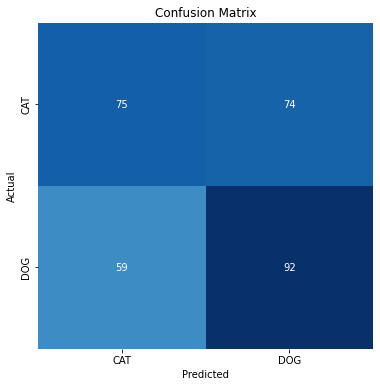

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.56      0.50      0.53       149
         DOG       0.55      0.61      0.58       151

    accuracy                           0.56       300
   macro avg       0.56      0.56      0.56       300
weighted avg       0.56      0.56      0.56       300



In [10]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)